### Comparison between Pi-Net and PolinomialActivadedNet

# Pinet

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def resnet_block(x, filters, activation_degree, rank=None):
    shortcut = x
    x = Dense(filters)(x)
    x = tf.keras.layers.Lambda(lambda y: polynomial_activation(y, degree=activation_degree))(x)

    if rank is not None:
        x = TensorDecompositionLayer(rank)(x)

    x = Dense(filters)(x)
    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_blocks, filters, activation_degree, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_degree, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
activation_degree = 3  # Change to 1 for 1st degree polynomial, 2 for 2nd degree, and 3 for 3rd degree
rank = 4  # Tensor decomposition rank, set to None if you don't want to use tensor decomposition

model = build_model(input_shape, num_blocks, filters, activation_degree, rank)
model.compile(optimizer='adam', loss='mse')


In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
# lower_bound = -2 * np.pi
# upper_bound = 2 * np.pi
lower_bound = -10
upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 1s 2ms/step - loss: 731.6659 - val_loss: 0.9881
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.7826 - val_loss: 0.7283
Epoch 3/200
125/125 [==============================] - 0s 1ms/step - loss: 0.7015 - val_loss: 0.6956
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6764 - val_loss: 0.6742
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6572 - val_loss: 0.6585
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6441 - val_loss: 0.6454
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6323 - val_loss: 0.6329
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6208 - val_loss: 0.6221
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.6130 - val_loss: 0.6203
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.5988 - val_

Validation loss: 0.00023438122298102826
32/32 [==============================] - 0s 544us/step


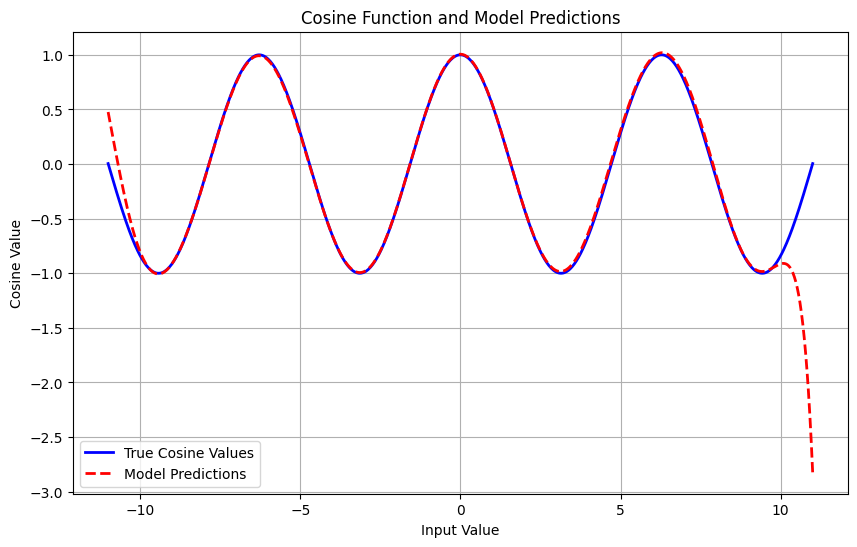

In [4]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(-11, 11, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


# Polinomial Architecture 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class PolynomialLayer(Layer):
    def __init__(self, **kwargs):
        super(PolynomialLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.a = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.c = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(PolynomialLayer, self).build(input_shape)

    def call(self, x):
        return self.a + self.b * x + self.c * x**2

class FunctionCompositionLayer(Layer):
    def __init__(self, activation_1, activation_2, **kwargs):
        self.activation_1 = activation_1
        self.activation_2 = activation_2
        super(FunctionCompositionLayer, self).__init__(**kwargs)

    def call(self, x):
        x = self.activation_1(x)
        x = self.activation_2(x)
        return x

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    elif degree ==4:
        return x**4
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

def resnet_block(x, filters, activation_1, activation_2, rank=None):
    shortcut = x
    x = Dense(filters)(x)
    x = PolynomialLayer()(x)
    x = FunctionCompositionLayer(activation_1, activation_2)(x)

    if rank is not None:
        x = TensorDecompositionLayer(rank)(x)

    x = Dense(filters)(x)
    x = Add()([x, shortcut])
    x = TensorDecompositionLayer(rank)(x)

    return x

def build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_1, activation_2, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
# activation_1 = tf.keras.activations.relu
activation_1 = lambda x: polynomial_activation(x, degree=2)
#activation_2 = tf.keras.activations.linear
activation_2 = lambda x: polynomial_activation(x, degree=1)

rank = 2

model = build_model(input_shape, num_blocks, filters, activation_1, activation_2, rank)
optimizer = Adam(learning_rate=0.00001) # Reduce learning rate
model.compile(optimizer='adam', loss='mse')


#### Both architectures have 10,000 samples in range -10, 10

#### The main difference is that Pi net requires 200 + epochs to train

#### Polinomial Network requires less than 200 epochs and the the loss function is smaller
Loss Pi Net  0.00023438122298102826
Loss Polinomial Func 2.0201952793286182e-05

In [2]:
import numpy as np

np.random.seed(42)
n_samples = 10000
#lower_bound = -2 * np.pi
#upper_bound = 2 * np.pi
lower_bound = -10
upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 2s 3ms/step - loss: 0.5207 - val_loss: 0.5268
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4919 - val_loss: 0.5132
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.4825 - val_loss: 0.4455
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.4210 - val_loss: 0.3910
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3647 - val_loss: 0.4673
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3381 - val_loss: 0.3112
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3579 - val_loss: 0.4811
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3864 - val_loss: 0.3199
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3025 - val_loss: 0.2975
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.3042 - val_lo

Validation loss: 2.0201952793286182e-05
32/32 [==============================] - 0s 640us/step


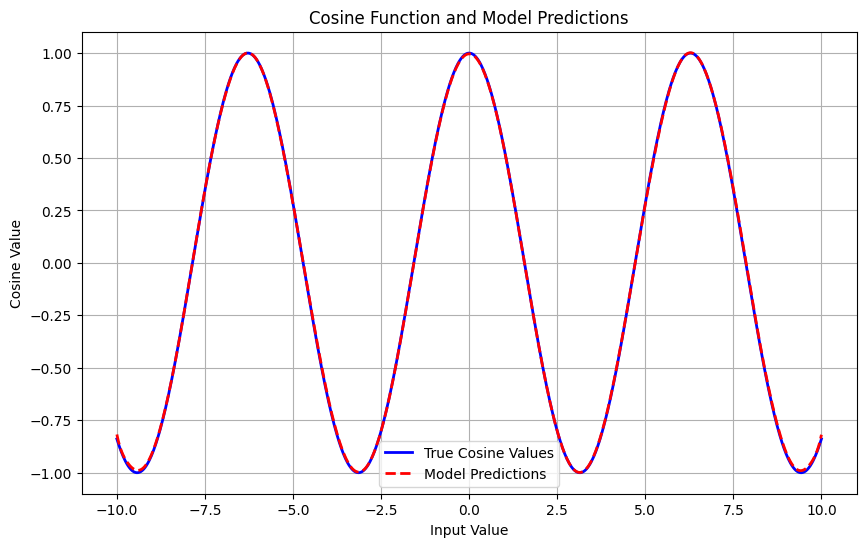

In [3]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()


### Less epochs means less training time, but in this case with higher accuracy

# Differences
* Pi net structure has a resnet architecture with a polinomial activation of degree 3
* It has a decomposition layer that helps keeping the tensors within a range and does not explodes the learning.


* Polinomial structure also has a resnet architecture but it has a layer in the form of a polinomial a + bx + cx*x
* This also has a Tensor Decomposition layer that helps with the learning
* It has two activation functions where one is X*X and the second one is just X

# PI NET WITH POLI LAYER

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class PolynomialLayer(Layer):
    def __init__(self, **kwargs):
        super(PolynomialLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.a = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        self.c = self.add_weight(shape=(input_shape[-1],),
                                 initializer='random_normal',
                                 trainable=True)
        super(PolynomialLayer, self).build(input_shape)

    def call(self, x):
        return self.a + self.b * x + self.c * x**2

def polynomial_activation(x, degree=1):
    if degree == 1:
        return x
    elif degree == 2:
        return x * x
    elif degree == 3:
        return x**3
    else:
        raise ValueError("Invalid degree specified, only 1st, 2nd and 3rd degree polynomials are supported.")

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer='random_normal',
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                         initializer='random_normal',
                                         trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

def resnet_block(x, filters, activation_degree, rank=None):
    shortcut = x
    x = Dense(filters)(x)
    x = PolynomialLayer()(x)
    x = tf.keras.layers.Lambda(lambda y: polynomial_activation(y, degree=activation_degree))(x)

    if rank is not None:
        x = TensorDecompositionLayer(rank)(x)

    x = Dense(filters)(x)
    x = Add()([x, shortcut])
    return x

def build_model(input_shape, num_blocks, filters, activation_degree, rank=None):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for _ in range(num_blocks):
        x = resnet_block(x, filters, activation_degree, rank)

    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

input_shape = (1,)
num_blocks = 3
filters = 16
activation_degree = 3  # Change to 1 for 1st degree polynomial, 2 for 2nd degree, and 3 for 3rd degree
rank = 4  # Tensor decomposition rank, set to None if you don't want to use tensor decomposition

model = build_model(input_shape, num_blocks, filters, activation_degree, rank)
model.compile(optimizer='adam', loss='mse')


In [4]:
import numpy as np

np.random.seed(42)
n_samples = 10000
# lower_bound = -2 * np.pi
# upper_bound = 2 * np.pi
lower_bound = -10
upper_bound = 10

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
y = np.cos(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

batch_size = 64
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))



Epoch 1/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2288 - val_loss: 0.2514
Epoch 2/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2138 - val_loss: 0.2169
Epoch 3/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2127 - val_loss: 0.3209
Epoch 4/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2783 - val_loss: 0.2117
Epoch 5/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2079 - val_loss: 0.1890
Epoch 6/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1944 - val_loss: 0.1887
Epoch 7/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2023 - val_loss: 0.1839
Epoch 8/200
125/125 [==============================] - 0s 1ms/step - loss: 0.2176 - val_loss: 0.1885
Epoch 9/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.1752
Epoch 10/200
125/125 [==============================] - 0s 1ms/step - loss: 0.1954 - val_lo

Validation loss: 0.0009504059562459588
32/32 [==============================] - 0s 624us/step


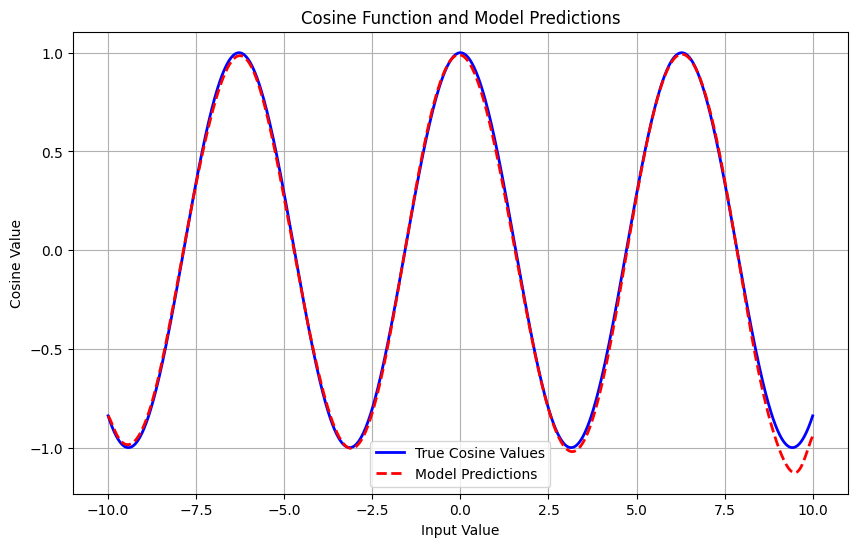

In [6]:
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(-10, 10, num=num_test_samples).reshape(-1, 1)
y_true = np.cos(X_test)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()
